### Optimal control of the Wilson-Cowan model
This notebook shows how to compute the optimal control (OC) signal for the Wilson-Cowan model for a simple example task.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [65]:
# We import the model
N = 3
cmat = np.ones((N,N))
model = WCModel(Cmat=cmat, Dmat=np.zeros((N,N)))
model.params.K_gl = 3.

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 20.
amplitude = 1.
period = duration /4.

zero_input = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input]*2) )[np.newaxis,:,:]
control = np.vstack( ([zero_input]*model.params.N))

control[0,0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well
control[1,0,10:30] = 1.
control[2,0,20:50] = np.linspace(0,1,30)

print(control.shape)

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
model.params["exc_init"] = np.zeros((model.params.N, 1))
model.params["inh_init"] = np.zeros((model.params.N, 1))

(3, 2, 201)


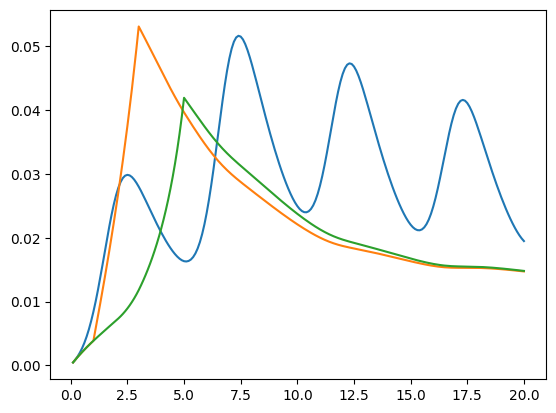

(3, 2, 201)


In [66]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = control[:,0,:]
model.params["inh_ext"] = control[:,1,:]
model.run()

for n in range(N):
    plt.plot(model.t, model.exc[n,:])
plt.show()

state = getstate()
print(state.shape)

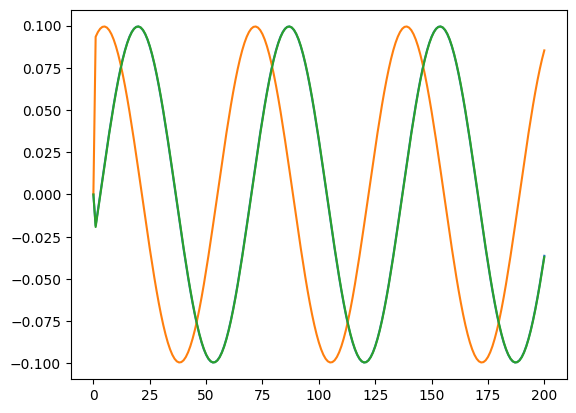

(3, 2, 201)


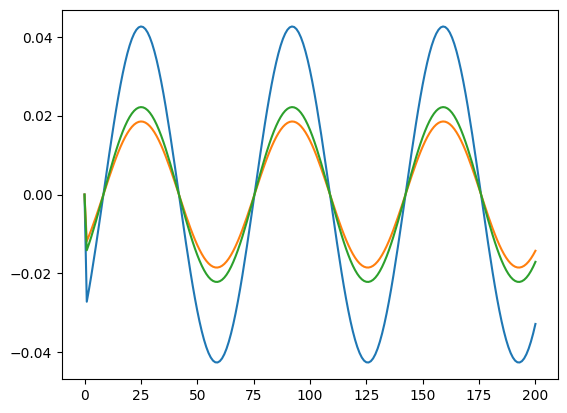

In [74]:
fsync = cost_functions.derivative_fourier_cost(state[:,:,:], dt, 8, np.ones((4,2)), [0,1001])

for n in range(fsync.shape[0]):
    plt.plot(fsync[n,0,:])
plt.show()

fsync_an = cost_functions.derivative_fourier_cost_an(state[:,:,:], dt, 8, np.ones((4,2)), [0,1001])
print(fsync_an.shape)

for n in range(fsync_an.shape[0]):
    plt.plot(fsync_an[n,0,:])
plt.show()

In [44]:
def getstate():
    xs_begin = np.concatenate((model.params["exc_init"], model.params["inh_init"]), axis=1)[:, :, np.newaxis]
    x1 = np.stack((model.exc, model.inh), axis=1)
    xs = np.concatenate((xs_begin,x1),axis=2 )
    return xs